# Predict the Number of Taxi Orders for the Next Hour

### Table of Contents
* [Project Descriptions](#scrollTo=bAoMZ72T7xOE)
    * [Objective](#scrollTo=bAoMZ72T7xOE)
    * [Initialization](#scrollTo=bAoMZ72T7xOE)
    * [1. Preparation](#scrollTo=GwbmtUIB7xOZ)
        * [1.1. Resampling](#scrollTo=Uy8MRBEE7xOZ)
        * [1.2. Features Engineering](#scrollTo=5uCmCFUY7xOe)
    * [2. Analysis](#scrollTo=a_iyuEhY7xOi)
    * [3. Training](#scrollTo=flskSEe47xOn)
        * [3.1. ARIMA](#scrollTo=b8Z2nScU7xOq)
    * [4. Testing](#scrollTo=SQqssVvn7xOw)
        * [4.1. Linear Regression](#scrollTo=ruDqqH1Y7xOx)
        * [4.2. Random Forest Regressor](#scrollTo=iqTCk0lM7xOz)
        * [4.3. XGBoost](#scrollTo=6mLWU3HK7xO0)
        * [4.4. CatBoost](#scrollTo=UjSxHOZW7xO1)
        * [4.5. LightGBM](#scrollTo=nJvWsZIz7xO2)
* [Consclusions](#scrollTo=2VtINquE7xO4)

## Time Series

A taxi company called Sweet Lift has collected historical data on taxi orders at the airport. It needs to predict the number of taxi orders for the next hour to attract more drivers at peak hours. We will model such a prediction.

The RMSE metric on the *test set* should be at most 48.

### Objective

1. Download the data and perform *resampling* within one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial *dataset*.
4. Test the data using the test samples and provide conclusions.

## Initialization <a class="anchor" id="Data Description"></a>

The data is stored in the `taxi.csv` file. The number of orders in the `num_orders` column.

In [1]:
# import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

# stats library
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA

# ml libraries
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

## 1.  Data Preparation

In [2]:
# load the dataset
df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/taxi.csv')

In [3]:
# print the first 5 data
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
# print the last 5 data
df.tail()

,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


In [5]:
# print the information of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


- The initial data has 26496 rows, and there are only two columns, namely the date column and the number of taxi orders every 10 minutes.

In [6]:
# print the statistic descriptive of data
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
# check if there are any missing values
df.isnull().sum()

datetime      0
num_orders    0
dtype: int64

In [8]:
# check if there are any duplicates
df.duplicated().sum()

0

- There are no missing values and duplicate data.

In [9]:
# convert datetime to timestamp format
df['datetime'] =  pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S.%f')

In [10]:
# datetime to index
df.set_index('datetime', inplace=True)

- We have converted the `datetime` column into timestamp format and converted the column to index.

**Summary**:
- The dataset contains the number of taxi bookings from the airport every 10 minutes from March 2018 to August 2018.
- We did not find any missing values or duplicates in the dataset.
- To perform the analysis, we must convert the date column into `timestamp` format.

Next step, we need to do resampling by summing the data every 10 minutes into one hour and performing feature engineering to train the model.

### 1.1. Resampling

We will resample the order time into one hour.

In [11]:
# print the sample of data
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [12]:
# resample the data
df = df.resample('1H').sum().reset_index()

In [13]:
df.set_index('datetime', inplace=True)

In [14]:
# checking data information 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [15]:
# new df ratio
4416 / 26496  * 100

16.666666666666664

- There are 4416 rows left after resampling, then we will perform feature engineering and look at the data distribution.

**Summary:**
- We have resampled the data to one hour so that the remaining data is only 16% of the data before resampling.
- We also converted the `DateTime` column to the index to facilitate data exploration and model building.

Next, we will do feature engineering to add new valuable columns in the model building.

### 1.2. Features Engineering

In [16]:
# create make features function
def make_features(data, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )


make_features(df, 5, 10)

In [17]:
# print df sample
df.tail()

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-08-31 19:00:00,136,8,31,19,4,207.0,217.0,197.0,116.0,133.0,173.3
2018-08-31 20:00:00,154,8,31,20,4,136.0,207.0,217.0,197.0,116.0,166.6
2018-08-31 21:00:00,159,8,31,21,4,154.0,136.0,207.0,217.0,197.0,162.9
2018-08-31 22:00:00,223,8,31,22,4,159.0,154.0,136.0,207.0,217.0,162.1
2018-08-31 23:00:00,205,8,31,23,4,223.0,159.0,154.0,136.0,207.0,170.8


- We add 5 [lag features](https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0), which are helpful because they are built on the assumption that what happened in the past can influence or contain some intrinsic information about the future.
- We defined a [rolling window](https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0) of 10 to compute statistics on the values from a given data sample by determining a range that includes the model itself as well as some specified number of pieces before and after the selection used.
- We also added columns such as a month, date, and hour to know when the taxi order occurred.

## 2. Analysis

In [18]:
# create new df without features
df_clean = df[['num_orders']]

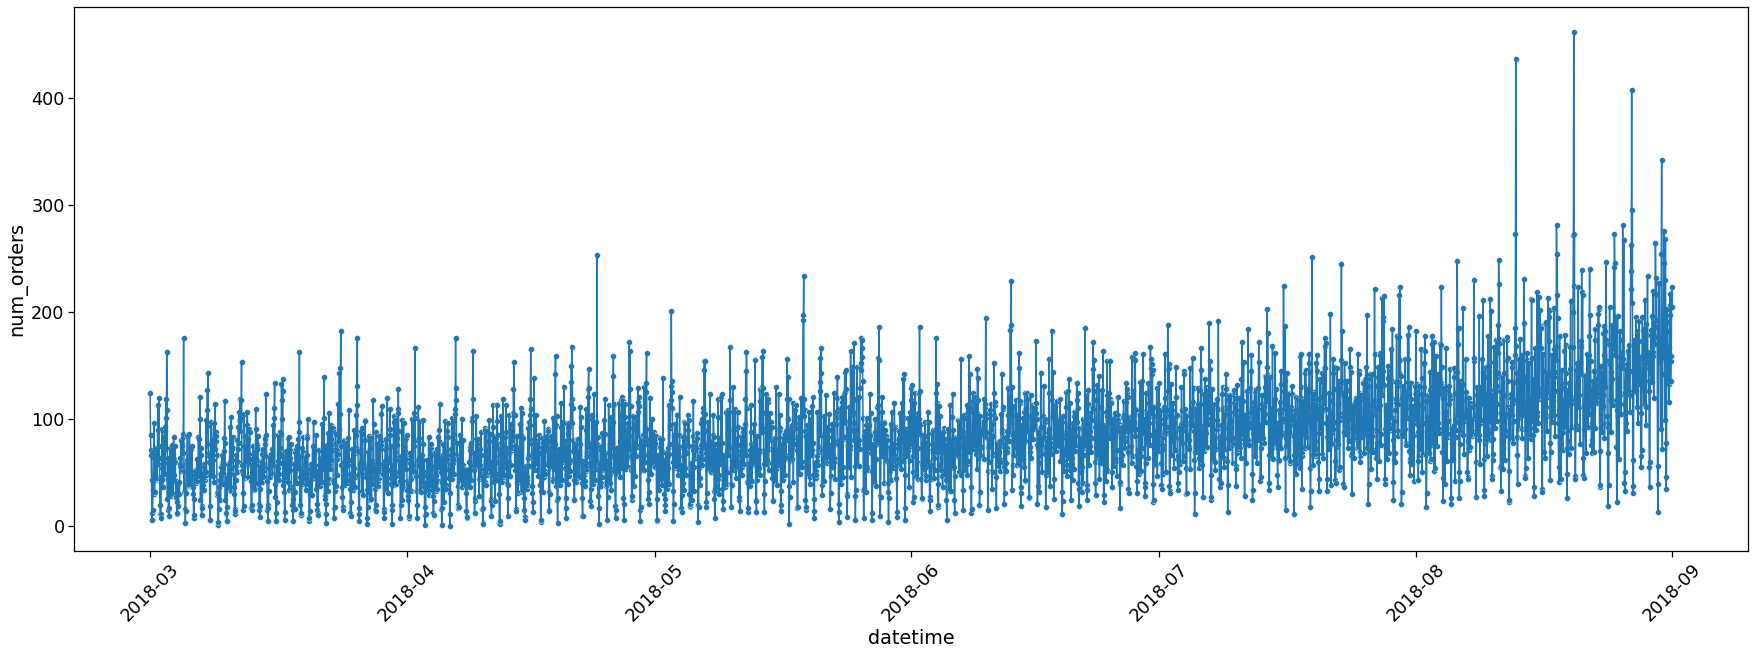

In [19]:
# Display the distribution of the number of taxi orders
plt.figure(figsize = (30,10))
sns.set_context(context='notebook', font_scale=1.6)
sns.scatterplot(x='datetime', y ='num_orders', data=df)
sns.lineplot(x='datetime', y='num_orders', data=df)
plt.xticks(rotation=45)
plt.show()

From the diagram above, we see that the distribution of taxi bookings shows a non-stationary distribution. However, we see that the distribution of taxi bookings remains the same in the early months. To clarify, we must look at the allotment with seasonal decomposition.

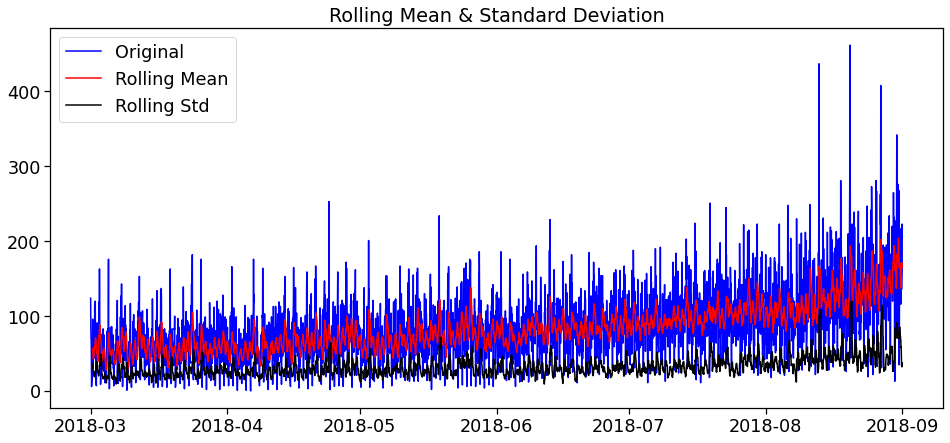

In [20]:
# display mean and standard deviation
rolLmean = df_clean.rolling(12).mean()
rolLstd = df_clean.rolling(12).std()

plt.figure(figsize=(16,7))
fig = plt.figure(1)

#Plot rolling statistics:
orig = plt.plot(df_clean, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Because of the large amount of data, it is quite difficult for us to see the trend in the data, although we can see that the trend in the graph above is increasing we will visualize the data with the seasonal decompose method.

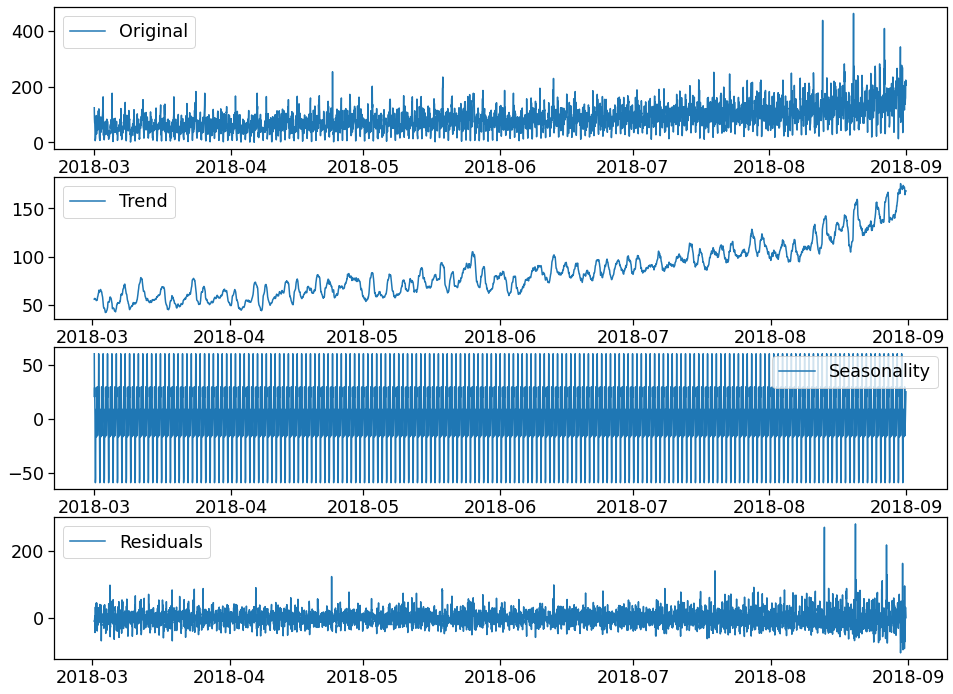

In [21]:
# display the data trend and seasonality

decomposition = seasonal_decompose(df_clean)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,12))
fig = plt.figure(1)

plt.subplot(411)
plt.plot(df_clean, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

From the diagram above, it is clear that the trend of taxi bookings is increasing every month, although it is not very significant in the early months.

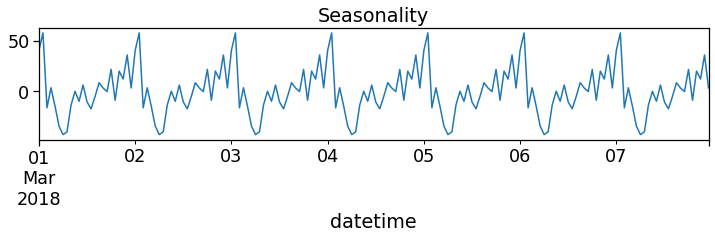

In [22]:
# resample and display the data seasonality in march
decomposed_resample = seasonal_decompose(df_clean['2018-03-01':'2018-03-07'])

plt.figure(figsize=(12, 7))
plt.subplot(312)
decomposed_resample.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

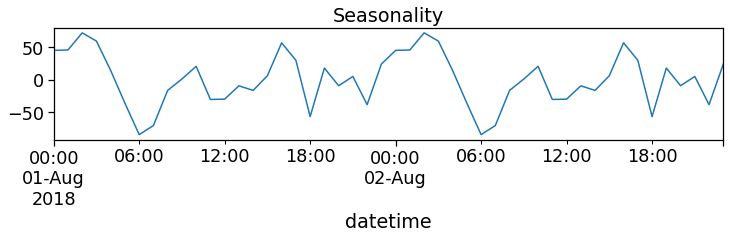

In [23]:
# resample and display the data seasonality in august
decomposed_resample = seasonal_decompose(df_clean['2018-08-01':'2018-08-02'])

plt.figure(figsize=(12, 7))
plt.subplot(312)
decomposed_resample.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

- We resampled the first week of March and the first two days of August to see the data distribution based on seasonality, showing that the number of taxi bookings from the airport peaks at 00:00 or midnight. It could happen because, at midnight, taxis are the only mode of transportation available at the airport, so customers do not have other alternatives.
- 6 am is the least taxi booking time. It could be because most airlines are about to take off then, and only a few planes have landed at the airport.

## 3. Training

In [24]:
# def rmse function
def rmse(y_actual, y_pred):

  return np.sqrt(mean_squared_error(y_actual, y_pred))

In [25]:
# train test split ratio
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [26]:
# train test split features and target
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

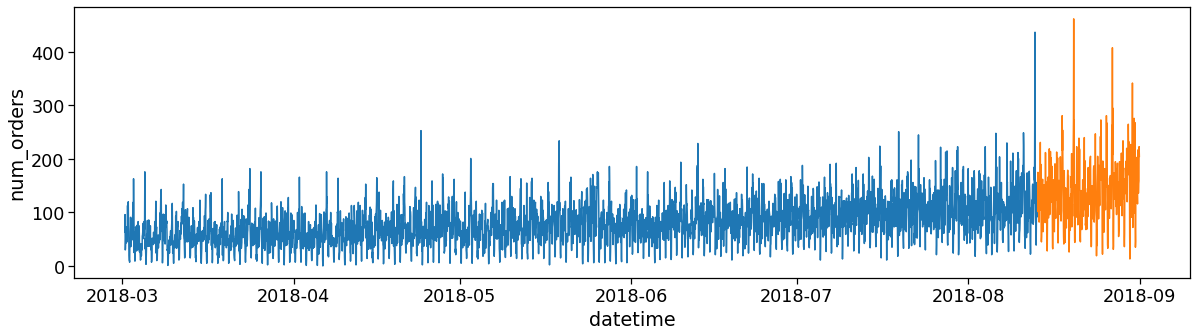

In [27]:
# display the distribution data train and test
plt.figure(figsize=(20,5))
sns.lineplot(features_train.index, target_train);
sns.lineplot(features_test.index, target_test);
plt.show()

- The diagram above is a visualization of the number of taxi bookings from the train and test data. 
- We split the train and test data with a ratio of 90:10.

### 3.1. ARIMA 

In [28]:
# ARIMA model
y = target_train

ARIMAmodel = ARIMA(y, order = (5, 0, 10))
ARIMAmodel = ARIMAmodel.fit()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


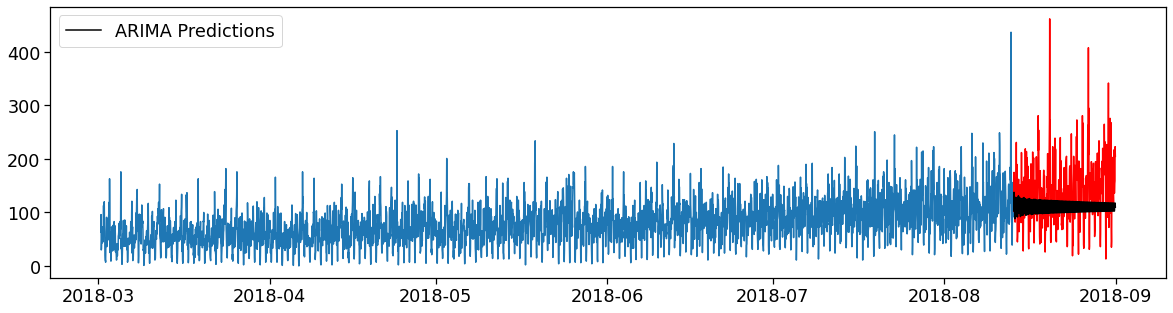

In [29]:
y_pred = ARIMAmodel.get_forecast(len(target_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = target_test.index
y_pred_out = y_pred_df['predictions'] 

plt.figure(figsize=(20,5))
plt.plot(target_train)
plt.plot(target_test, color='red')
plt.plot(y_pred_out, color='black', label='ARIMA Predictions')
plt.legend()
plt.show()

In [30]:
# ARIMA rmse
rmse(target_test, y_pred_out)

63.916933056245256

The ARIMA model produces a fairly high rmse value and passes the specified thresholds, the model we will create should produce a lower rmse value than the ARIMA model.

## 4. Testing

### 4.1. Linear Regression

In [31]:
# training the algorithm
lin_reg = LinearRegression()  
lin_reg.fit(features_train, target_train)

# linear regression model predict
y_pred_train_lr = lin_reg.predict(features_train)
y_pred_test_lr = lin_reg.predict(features_test)

In [32]:
# evaluation metric results linear regression
print('Root Mean Squared Error Train:', rmse(target_train, y_pred_train_lr))
print('Root Mean Squared Error Test:', rmse(target_test, y_pred_test_lr))

Root Mean Squared Error Train: 30.49157375237362
Root Mean Squared Error Test: 53.10022806364771


We can make the linear regression model as a baseline for reference results from several models that we will train next, even though in this model the RMSE value does not reach the specified threshold value.

### 4.2. Random Forest Regressor

In [33]:
%%time

# rmse score random forest model training and test set 
print('Random Forest Model')
results = defaultdict(list)

for n in [1, 2, 4, 5, 10, 17, 20, 26, 30]:
    model = RandomForestRegressor(random_state=42, max_depth=n, n_estimators=100)
    model.fit(features_train, target_train)
    
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    results['max_depth'].append(n)
    results['train_rmse'].append(np.sqrt(mean_squared_error(target_train, pred_train)))
    results['test_rmse'].append(np.sqrt(mean_squared_error(target_test, pred_test)))
    
display(pd.DataFrame(results))

Random Forest Model


,max_depth,train_rmse,test_rmse
0,1,33.722611,74.000612
1,2,30.201922,68.428819
2,4,25.648989,57.940059
3,5,24.062795,55.451720
4,10,15.257934,47.281049
5,17,8.827360,45.750214
6,20,8.505859,45.702836
7,26,8.437636,46.042600
8,30,8.439656,46.267608


CPU times: user 15.9 s, sys: 123 ms, total: 16 s
Wall time: 16 s


- The random forest model obtained better results than the linear regression model. 
- In this model, the best results were obtained by setting the max_depth parameter to 10.

### 4.3. XGBoost

In [34]:
%%time

# rmse score random forest model training and test set 
print('XGBoost Model')
results = defaultdict(list)

for n in range(1, 11):
    model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=n)
    model.fit(features_train, target_train)
    
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    results['max_depth'].append(n)
    results['train_rmse'].append(rmse(target_train, pred_train))
    results['test_rmse'].append(rmse(target_test, pred_test))
    
display(pd.DataFrame(results))

XGBoost Model


,max_depth,train_rmse,test_rmse
0,1,24.569680,50.108797
1,2,20.598736,49.053816
2,3,17.581877,48.289363
3,4,14.535105,45.037670
4,5,10.824439,45.126398
5,6,7.050929,47.241706
6,7,4.074987,49.612434
7,8,2.270489,53.132183
8,9,0.989431,53.862239
9,10,0.309026,55.813108


CPU times: user 4min 4s, sys: 1.14 s, total: 4min 5s
Wall time: 4min 7s


- With not too many features we get a fairly short training time on the XGBoost model. 
- Temporarily the best results with the lowest RMSE value are obtained from this model with a max_dept value of 5 and an RMSE result of 45.126398.

### 4.4. CatBoost

In [35]:
%%time

# rmse score random forest model training and test set 
print('CatBoost Model')
results = defaultdict(list)

for n in range(1, 11):
    model = cb.CatBoostRegressor(loss_function='RMSE', depth=n, iterations=150, random_seed=42)
    model.fit(features_train, target_train, verbose=False)
    
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    results['max_depth'].append(n)
    results['train_rmse'].append(rmse(target_train, pred_train))
    results['test_rmse'].append(rmse(target_test, pred_test))
    
display(pd.DataFrame(results))

CatBoost Model


,max_depth,train_rmse,test_rmse
0,1,24.579963,50.807173
1,2,21.215863,47.526362
2,3,19.383648,47.843906
3,4,17.862334,42.986758
4,5,16.632264,42.574434
5,6,15.042500,43.854223
6,7,13.589860,49.262132
7,8,11.406639,47.290737
8,9,10.040610,46.638845
9,10,7.627698,48.889379


CPU times: user 8.43 s, sys: 117 ms, total: 8.55 s
Wall time: 9.51 s


- The CatBoost model has the shortest training time of the previous two models. 
- Of the previous models, the CatBoost model has the best performance with the lowest RMSE value of 42.574434.

### 4.5. LightGBM

In [36]:
%%time

# rmse score random forest model training and test set 
print('LightGBM Model')
results = defaultdict(list)

for n in [10, 20, 30, 50, 70, 100]:
    model = lgbm.LGBMRegressor(objective='rmse', num_leaves=n, max_depth=10)
    model.fit(features_train, target_train)
    
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    results['num_leaves'].append(n)
    results['train_rmse'].append(rmse(target_train, pred_train))
    results['test_rmse'].append(rmse(target_test, pred_test))
    
display(pd.DataFrame(results))

LightGBM Model


,num_leaves,train_rmse,test_rmse
0,10,19.447900,44.350819
1,20,16.894380,44.114176
2,30,15.201356,44.165117
3,50,13.536870,43.472545
4,70,12.933502,44.520137
5,100,12.288221,43.785144


CPU times: user 1min 36s, sys: 645 ms, total: 1min 36s
Wall time: 1min 38s


- Although the LightGBM model is the most superior in training time speed and is relatively stable in results even if we change some parameters, the CatBoost model has the best performance in results and with less significant time.

**Conclusions:**
- From several training models, we found the best model in the CatBoost model with a max_dept parameter of 5.
- This model has the lowest rmse value in the test results, although it has a considerable difference with the rmse results from the train data.

### 4.6. Best Model Visualization

In [37]:
# train catboost best model 

catboost = cb.CatBoostRegressor(loss_function='RMSE', depth=5, iterations=150, random_seed=42)
catboost.fit(features_train, target_train, verbose=False)
    
pred_train_cb = catboost.predict(features_train)
pred_test_cb = catboost.predict(features_test)
    
cb_pred = pd.DataFrame(pred_test_cb)
cb_pred.index = target_test.index

rmse(target_train, pred_train_cb), rmse(target_test, pred_test_cb)

(16.632264179583565, 42.57443350106846)

In [38]:
# create new catboost prediction dataset
result_cb = pd.concat([target_test, cb_pred], axis=1).reindex(target_test.index)
result_cb.head()

,num_orders,0
datetime,,
2018-08-13 14:00:00,102,92.334261
2018-08-13 15:00:00,175,109.706877
2018-08-13 16:00:00,144,155.921958
2018-08-13 17:00:00,152,125.540127
2018-08-13 18:00:00,104,109.937727


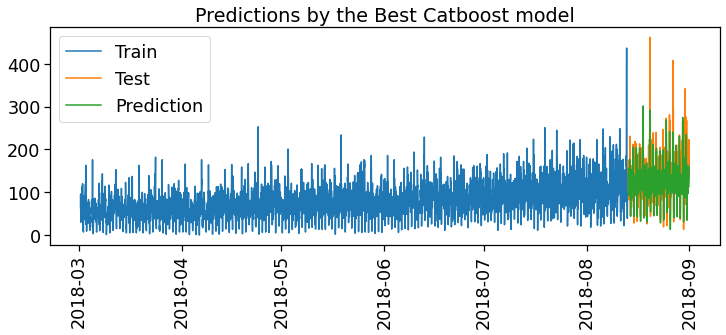

In [39]:
# display catboost predictions plot
plt.figure(figsize=(12,4))
plt.plot(target_train.index, target_train, label='Train')
plt.plot(target_test.index, target_test, label='Test')
plt.plot(result_cb.index, result_cb[0], label='Prediction')
plt.xticks(rotation='vertical')
plt.legend(loc='best')
plt.title('Predictions by the Best Catboost model')
plt.show()

- From the graph above we can see the prediction results of the CatBoost model with the best parameters we get, we see that the prediction results are quite close to the pattern of the actual data.
- With these results we can rely on this model to help the company in forecasting to determine the number of taxi bookings that will occur in the future.

# Consclusions

**1. Data Preparation**
- Our data contains a collection of time and number of taxi bookings from the airport.
- No missing values and duplicates were found.

**2. EDA and Data Visualization**
- The trend of taxi bookings increases every month, although not significantly in the early months.
- We resampled the first week of March and the first two days of August to see the distribution of data based on seasonality, showing the number of taxi bookings from the airport peaks at 00:00 or 12pm, this could be because at midnight taxis are the only mode of transportation available at the airport so customers do not have other alternatives.
- 6am is the least taxi booking time, this could be because at that time most airlines are just about to take-off and not many planes have landed at the airport.

**3. Features Engineering**
- We perform feature engineering by adding 5 lag columns, and setting a rolling window of 10 with an average value.

**4. Model Analysis**
- From several training models that we did, we found the best model in the CatBoost model with a max_dept parameter of 5.
- This model has the lowest rmse value in the test results, although it has a considerable difference with the rmse results from the train data.

**Recommendation**

Following these guidelines will help a taxi business run smoothly during rush hour:

- Recruit more drivers: During peak hours, the company can hire more drivers based on estimates of the number of taxi orders for the following hour. It will make it more likely that there will be enough drivers to satisfy customer demand.

- Optimize the locations of the drivers who are accessible in order to decrease customer wait periods. Each driver's location can be tracked using GPS information, and they can be assigned to pickups that are near to where they are right now.

- Provide incentives to drivers: By providing drivers with increased pay rates, bonuses, or other rewards, the company can encourage them to work during peak hours. Thus, it can be made clear that

- Provide incentives to drivers: By providing drivers with increased pay rates, bonuses, or other rewards, taxi companies can encourage them to work during peak hours. This may guarantee that there are sufficient drivers on hand during rush hour.

- Enhance dispatching: To manage driver availability and satisfy customer demand, a dispatching system that works well is essential. The software can be used to automatically allocate pickups to drivers based on their availability and location as well as to optimize routes to shorten wait times for customers.

- Customers should be given real-time information about potential wait periods during peak hours. Real-time updates on expected wait times and the status of taxi requests are crucial for reducing frustration. It can lower client complaints and raise satisfaction levels generally.

A taxi business can efficiently manage driver availability and satisfy customer demand during peak hours by adhering to these suggestions. This can raise sales for the business and increase customer happiness.
